# Ứng dụng Nerual Network trong nhận dạng chữ số

Module này mình hoạ feedforward neural network với sô layer bất kỳ. Những khái niệm về linear projection sẽ được đưa ra thông qua matrix multiplication, non-linear transformaiton.

## Import những thư viện cần thiết

In [60]:
# Python imports
import numpy as np # Matrix and vector computation package
import matplotlib.pyplot as plt  # Plotting library
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the tutorial is reproducable
np.random.seed(seed=1)
from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics, cross_validation # data and evaluation utils, 
from matplotlib.colors import colorConverter, ListedColormap # some plotting functions
import itertools
import collections

## Handwritten digits dataset

Tập dataset sử dụng được cung cấp bởi scikit-learn. Tập này bao gồm 1797 8x8 images số được viết bằng tay từ 0 - 9. Tập dataset này nhỏ hơn rất nhiều so với tập MNIST.

In [61]:
# load the data from scikit-learn
digits = datasets.load_digits()

# Load the targets
# Note that the targets are stored as digits, these need to be
# converted to one-hot-encoding for the output sofmax layer.
T = np.zeros((digits.target.shape[0], 10))
T[np.arange(len(T)), digits.target] += 1

# Devide the data into a train and test set.
X_train, X_test, T_train, T_test = cross_validation.train_test_split(digits.data, T, test_size=0.4)

# Devide the test set into a validation set and final test set.
X_validation, X_test, T_validation, T_test = cross_validation.train_test_split(X_test, T_test, test_size=0.5)

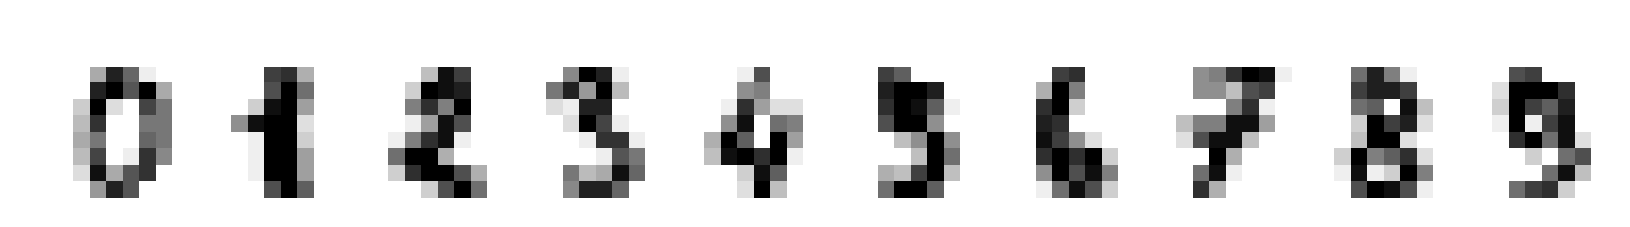

In [79]:
# Plot an example of each image.
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(10, 1), dpi=100)
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    ax.matshow(digits.images[i], cmap='binary') 
    ax.axis('off')
plt.show()

## Generalization of the layers

In [63]:
# Define the non-linear functions used
def logistic(z):
    return 1 / (1 + np.exp(-z))

def logistic_deriv(y):
    return np.multiply(y, (1 - y))

def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

In [64]:
# Define layers used in this model
class Layer(object):
    """Base class for the different layers.
    Defines base methods and documentation of methods."""
    
    def get_params_iter(self):
        return []
    
    def get_params_grad(self, X, output_grad):
        return []
    
    def get_output(self, X):
        pass
    
    def get_input_grad(self, Y, output_grad=None, T=None):
        pass

In [65]:
class LinearLayer(Layer):
    """The linear layer performs a linear transformation to its input."""
    
    def __init__(self, n_in, n_out):
        """Initialize hidden layer parameters.
        n_in is the number of input variables.
        n_out is the number of output variables."""
        self.W = np.random.randn(n_in, n_out) * 0.1
        self.b = np.zeros(n_out)
        
    def get_params_iter(self):
        """Return an iterator over the parameters."""
        return itertools.chain(np.nditer(self.W, op_flags=['readwrite']),
                                np.nditer(self.b, op_flags=['readwrite']))
    
    def get_output(self, X):
        """Perform the forward step linear transformation."""
        return X.dot(self.W) + self.b
    
    def get_params_grad(self, X, output_grad):
        """Return a list of gradients over the parameters."""
        JW = X.T.dot(output_grad)
        Jb = np.sum(output_grad, axis=0)
        return [g for g in itertools.chain(np.nditer(JW), np.nditer(Jb))]
    
    def get_input_grad(self, Y, output_grad):
        """Return the gradient at the inputs of this layer."""
        return output_grad.dot(self.W.T)

In [66]:
class LogisticLayer(Layer):
    """The logistic layer applies the logistic function to its inputs."""
    
    def get_output(self, X):
        """Perform the forward step transformation."""
        return logistic(X)
    
    def get_input_grad(self, Y, output_grad):
        """Return the gradient at the inputs of this layer."""
        return np.multiply(logistic_deriv(Y), output_grad)

In [67]:
class SoftmaxOutputLayer(Layer):
    """The softmax output layer computes the classification propabilities at the output."""
    
    def get_output(self, X):
        """Perform the forward step transformation."""
        return softmax(X)
    
    def get_input_grad(self, Y, T):
        """Return the gradient at the inputs of this layer."""
        return (Y - T) / Y.shape[0]
    
    def get_cost(self, Y, T):
        """Return the cost at the output of this output layer."""
        return - np.multiply(T, np.log(Y)).sum() / Y.shape[0]

## Mô hình mạng

In [68]:
# Define a sample model to be trained on the data
hidden_neurons_1 = 20 # Number of neurons in the first hidden-layer
hidden_neurons_2 = 20 # Number of neurons in the second hidden-layer

# Create the model
layers = [] # Define a list of layers
# Add first hidden layer
layers.append(LinearLayer(X_train.shape[1], hidden_neurons_1))
layers.append(LogisticLayer())
# Add second hidden layer
layers.append(LinearLayer(hidden_neurons_1, hidden_neurons_2))
layers.append(LogisticLayer())
# Add output layer
layers.append(LinearLayer(hidden_neurons_2, T_train.shape[1]))
layers.append(SoftmaxOutputLayer())

## Backpropagation

In [69]:
# Define the forward propagation step as a method
def forward_step(input_samples, layers):
    activations = [input_samples] # List of layer acctivations
    # Compute the forward activations for each layer starting from the first
    X = input_samples
    for layer in layers:
        Y = layer.get_output(X) # Get the output of the current layer
        activations.append(Y)
        X = activations[-1]
    return activations

In [70]:
# Define the backward propagation step as a method
def backward_step(activations, targets, layers):
    param_grads = collections.deque() # List of parameter gradients for each layer
    output_grad = None # The error gradient at the output of the current layer
    # Propagate the error backwards through all the layers.
    # Use reversed to iterate backwards over the list of layers.
    for layer in reversed(layers):
        Y = activations.pop() # Get the activations of the last layer on the stack
        # Compute the error at the output layer
        # The output layer error is calculated different then hidden layer error
        if output_grad is None:
            input_grad = layer.get_input_grad(Y, targets)
        else:
            input_grad = layer.get_input_grad(Y, output_grad)
            
        # Get the input of this layer (activations of the previous layer)
        X = activations[-1]
        # Compute the layer parameter gradients used to update the parameters
        grads = layer.get_params_grad(X, output_grad)
        
        param_grads.appendleft(grads)
        # Compute gradient at output of previous layer (input of current layer)
        output_grad = input_grad
    return list(param_grads)

## Tính sai số cho việc đạo hàm - Gradient

In [71]:
# Perform gradient checking
nb_samples_gradientcheck = 10 # Test the gradients on a subset of the data
X_temp = X_train[0:nb_samples_gradientcheck,:]
T_temp = T_train[0:nb_samples_gradientcheck,:]
# Get the parameter gradients with backpropagation
activations = forward_step(X_temp, layers)
param_grads = backward_step(activations, T_temp, layers)

# Set the small change to compute the numerical gradient
eps = 0.0001
# Compute the numerical gradients of the parameters in all layers.
for idx in range(len(layers)):
    layer = layers[idx]
    layer_backprop_grads = param_grads[idx]
    # Compute the numerical gradient for each parameter in the layer
    for p_idx, param in enumerate(layer.get_params_iter()):
        grad_backprop = layer_backprop_grads[p_idx]
        # + eps
        param += eps
        plus_cost = layers[-1].get_cost(forward_step(X_temp, layers)[-1], T_temp)
        # - eps
        param -= 2 * eps
        min_cost = layers[-1].get_cost(forward_step(X_temp, layers)[-1], T_temp)
        # reset param value
        param += eps
        # calculate numerical gradient
        grad_num = (plus_cost - min_cost)/(2*eps)
        # Raise error if the numerical grade is not close to the backprop gradient
        if not np.isclose(grad_num, grad_backprop):
            raise ValueError('Numerical gradient of {:.6f} is not close to the backpropagation gradient of {:.6f}!'.format(float(grad_num), float(grad_backprop)))
print('No gradient errors found')

No gradient errors found


## Lan truyền ngược - Backpropagation

In [72]:
# Create the minibatches
batch_size = 25  # Approximately 25 samples per batch
nb_of_batches = X_train.shape[0] / batch_size  # Number of batches

# Create batches (X,Y) from the training set
XT_batches = zip(
    np.array_split(X_train, nb_of_batches, axis=0),  # X samples
    np.array_split(T_train, nb_of_batches, axis=0))  # Y targets


In [73]:
# Define a method to update the parameters
def update_params(layers, param_grads, learning_rate):
    for layer, layer_backprop_grads in zip(layers, param_grads):
        for param, grad in itertools.izip(layer.get_params_iter(), layer_backprop_grads):
            # The parameter returned by the iterator point to the memory space of
            #  the original layer and can thus be modified inplace.
            param -= learning_rate * grad  # Update each parameter

In [74]:
# Perform backpropagation
# initalize some lists to store the cost for future analysis        
minibatch_costs = []
training_costs = []
validation_costs = []

max_nb_of_iterations = 300  # Train for a maximum of 300 iterations
learning_rate = 0.1  # Gradient descent learning rate

# Train for the maximum number of iterations
for iteration in range(max_nb_of_iterations):
    for X, T in XT_batches:  # For each minibatch sub-iteration
        activations = forward_step(X, layers)  # Get the activations
#         print "activations = ", len(activations)
        minibatch_cost = layers[-1].get_cost(activations[-1], T)  # Get cost
        minibatch_costs.append(minibatch_cost)
        param_grads = backward_step(activations, T, layers)  # Get the gradients
        update_params(layers, param_grads, learning_rate)  # Update the parameters
    # Get full training cost for future analysis (plots)
    activations = forward_step(X_train, layers)
    train_cost = layers[-1].get_cost(activations[-1], T_train)
    training_costs.append(train_cost)
    # Get full validation cost
    activations = forward_step(X_validation, layers)
    validation_cost = layers[-1].get_cost(activations[-1], T_validation)
    validation_costs.append(validation_cost)
#     if len(validation_costs) > 3:
#         # Stop training if the cost on the validation set doesn't decrease
#         #  for 3 iterations
#         if validation_costs[-1] >= validation_costs[-2] >= validation_costs[-3]:
#             break
    
nb_of_iterations = iteration + 1  # The number of iterations that have been executed

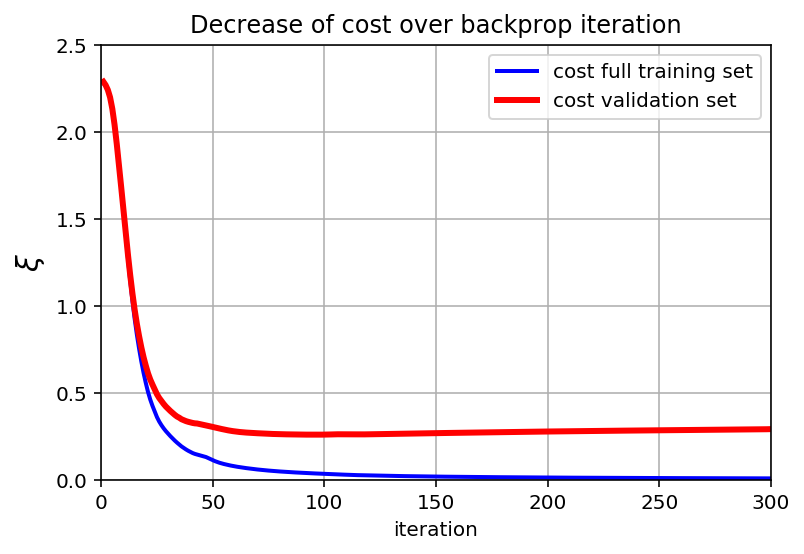

In [80]:
# Plot the minibatch, full training set, and validation costs
%config InlineBackend.figure_format = 'retina'
minibatch_x_inds = np.linspace(0, nb_of_iterations, num=nb_of_iterations*nb_of_batches)
iteration_x_inds = np.linspace(1, nb_of_iterations, num=nb_of_iterations)
# Plot the cost over the iterations
# plt.plot(minibatch_x_inds, minibatch_costs, 'g-', linewidth=0.5, label='cost minibatches')
plt.plot(iteration_x_inds, training_costs, 'b-', linewidth=2, label='cost full training set')
plt.plot(iteration_x_inds, validation_costs, 'r-', linewidth=3, label='cost validation set')
# Add labels to the plot
plt.xlabel('iteration')
plt.ylabel('$\\xi$', fontsize=15)
plt.title('Decrease of cost over backprop iteration')
plt.legend()
x1,x2,y1,y2 = plt.axis()
plt.axis((0,nb_of_iterations,0,2.5))
plt.grid()
plt.show()

## Test kết quả với mô hình học được

In [76]:
# Get results of test data
y_true = np.argmax(T_test, axis=1)  # Get the target outputs
activations = forward_step(X_test, layers)  # Get activation of test samples
y_pred = np.argmax(activations[-1], axis=1)  # Get the predictions made by the network
print y_true
print y_pred
test_accuracy = metrics.accuracy_score(y_true, y_pred)  # Test set accuracy
print('The accuracy on the test set is {:.2f}'.format(test_accuracy))

[3 4 4 4 0 4 5 7 7 0 5 3 7 3 6 4 5 1 1 0 7 3 3 1 0 4 2 3 0 6 2 3 7 9 3 7 9
 1 5 4 3 0 1 5 8 8 1 3 4 8 7 5 8 6 9 1 7 8 0 3 3 4 3 2 0 0 2 5 5 0 2 0 8 9
 4 5 5 0 3 0 8 7 9 6 1 9 1 9 7 0 5 5 5 7 8 2 9 0 2 1 8 7 7 6 3 4 3 6 7 9 8
 3 0 5 7 9 5 9 9 0 7 7 0 6 1 9 3 2 5 9 3 0 3 4 0 0 9 7 7 1 2 9 9 7 4 1 5 3
 6 8 5 4 8 6 6 0 8 4 8 7 0 9 3 9 5 4 9 1 5 2 5 1 6 6 7 6 9 6 1 4 2 0 5 1 7
 9 5 1 6 9 4 8 9 4 6 2 3 1 9 3 4 5 2 0 0 7 1 6 4 6 0 4 9 0 1 6 3 4 5 4 0 1
 9 3 4 9 3 4 4 4 2 8 2 1 8 8 0 3 3 3 4 5 1 5 7 7 3 4 3 1 9 7 1 8 4 8 4 9 2
 3 8 4 2 4 5 8 4 8 8 0 6 2 7 1 2 7 5 2 2 4 7 0 9 9 7 2 1 2 4 1 8 0 0 5 0 1
 9 8 1 1 5 8 8 7 2 7 9 0 5 3 3 0 6 7 4 3 3 7 7 5 2 7 5 9 1 1 9 6 2 1 4 9 1
 8 8 2 5 6 0 7 3 3 4 6 0 7 7 6 2 8 0 5 8 6 8 2 7 7 4 1]
[3 4 4 4 0 4 5 7 7 0 5 3 7 3 6 4 8 1 1 0 7 3 3 1 0 4 2 2 0 6 2 3 7 9 3 7 9
 1 5 4 3 0 1 5 8 8 1 3 4 8 7 5 5 6 9 1 7 8 0 3 3 4 3 2 0 0 2 5 5 0 2 0 8 9
 4 5 5 0 3 0 8 7 9 6 1 9 1 9 7 0 5 5 5 7 8 2 9 0 2 1 8 7 7 6 3 4 3 6 7 9 8
 3 0 5 7 9 5 9 3 0 7 7 0 6 1 9 3 2 5 5 3 0 3

[3 4 4 4 0]


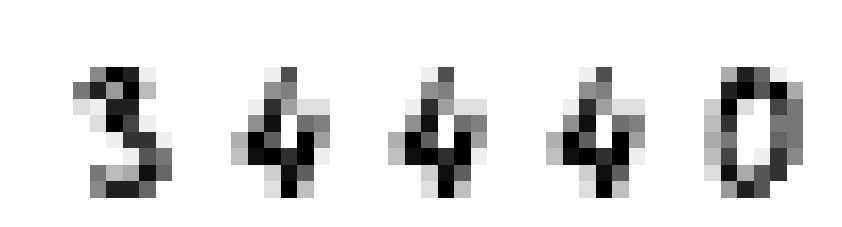

In [81]:
real_num = np.argmax(T_test[0:5], axis=1)
print real_num
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(10, 1), dpi=100)
for i in range(len(real_num)):
    ax = fig.add_subplot(1,10,i+1)
    ax.matshow(digits.images[real_num[i]], cmap='binary') 
    ax.axis('off')
plt.show()

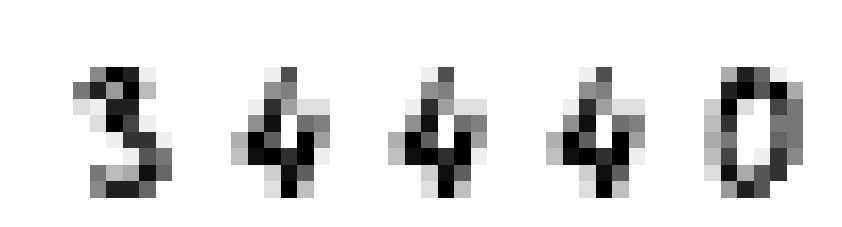

In [82]:
activations = forward_step(X_test[0:5], layers)  # Get activation of test samples
pred_num = np.argmax(activations[-1], axis=1)  # Get the predictions made by the network
print 
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(10, 1), dpi=100)
for i in range(len(pred_num)):
    ax = fig.add_subplot(1,10,i+1)
    ax.matshow(digits.images[pred_num[i]], cmap='binary') 
    ax.axis('off')
plt.show()